## 线性回归从零开始实现
### 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [4]:
# 默认将matplotlib 嵌入到notebook中
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$\pmb w=[2,-3.4]^\top、b=4.2$和噪声项$\epsilon$生成数据集极其标签：
$$
\pmb y = \pmb X \pmb w + b + \epsilon
$$

In [10]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    # 生成均值为0，方差为1，数量为`num_examples`, 列数为 w的矩阵
    X = torch.normal(0, 1, (num_examples, len(w)))
    # https://zhuanlan.zhihu.com/p/146707216
    # torch.matmul是多维矩阵乘法，类似于二维矩阵乘法: torch.mm
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    # reshape((-1,1))第一个-1表示自动推算第0维
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [11]:
print('features: ', features[0], '\nlabel:', labels[0])

features:  tensor([0.0289, 0.3806]) 
label: tensor([2.9421])


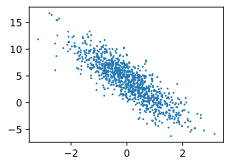

In [12]:
d2l.set_figsize()
# detach 表示将数据从计算图中分离出数据出来才能转为numpy
d2l.plt.scatter(features[:,-1].detach().numpy(), labels.detach().numpy(), 1)

## 定义一个```data_iter```函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为```batch_size```的小批量

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    ## 打散标号
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1158, -1.7760],
        [ 0.0325,  1.0804],
        [-0.3441,  2.4406],
        [ 1.4939, -0.3283],
        [ 0.4919,  1.7743],
        [ 0.8218, -0.6295],
        [-1.5179,  0.8396],
        [ 1.0652, -0.0523],
        [-0.2911,  0.1852],
        [-0.6110, -1.2916]]) 
 tensor([[ 8.0141],
        [ 0.5917],
        [-4.7680],
        [ 8.2807],
        [-0.8586],
        [ 7.9870],
        [-1.6905],
        [ 6.5030],
        [ 2.9841],
        [ 7.3676]])


## 定义初始化模型参数

In [41]:
# torch.normal表示均值为0，方差为0.01的
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [18]:
def linreg(X, w, b):
    """定义线性回归模型"""
    return torch.matmul(X,w) + b

## 定义损失函数 

In [23]:
def squared_loss(y_hat, y):
    """均方损失"""
    # y_hat 预测值, y是真实值
    # 虽然y和y_hat数量一样，一个可能是行向量，一个可能是列向量，为了统一起见，将y按照y_hat reshape
    # **2表示平方
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

In [27]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # 更新梯度的过程中，不参与梯度计算
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 定义训练过程

In [42]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        # 使用参数的梯度，更新参数
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        # 使用计算出来的w，b与真实值做loss
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1} loss {float(train_l.mean()):f}')

epoch 1 loss 0.055520
epoch 2 loss 0.000266
epoch 3 loss 0.000057
epoch 4 loss 0.000057
epoch 5 loss 0.000057
epoch 6 loss 0.000056
epoch 7 loss 0.000056
epoch 8 loss 0.000057
epoch 9 loss 0.000057
epoch 10 loss 0.000056


## 比较真实参数和训练学习到的参数来评估训练的成功程度

In [32]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0005, 0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0001], grad_fn=<RsubBackward1>)
